In [123]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
from scipy.optimize import fsolve
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import os
import itertools
import yfinance as yf
import requests


[*********************100%***********************]  1 of 1 completed
C:\Users\comte\AppData\Local\Temp\ipykernel_16904\2286655296.py:56: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  imp_vol = fsolve(BSM, sigma0, args=(S0, K, value, T, r, option_type), xtol=1e-6, maxfev=500)
C:\Users\comte\AppData\Local\Temp\ipykernel_16904\2286655296.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  imp_vols.append(float(imp_vol))


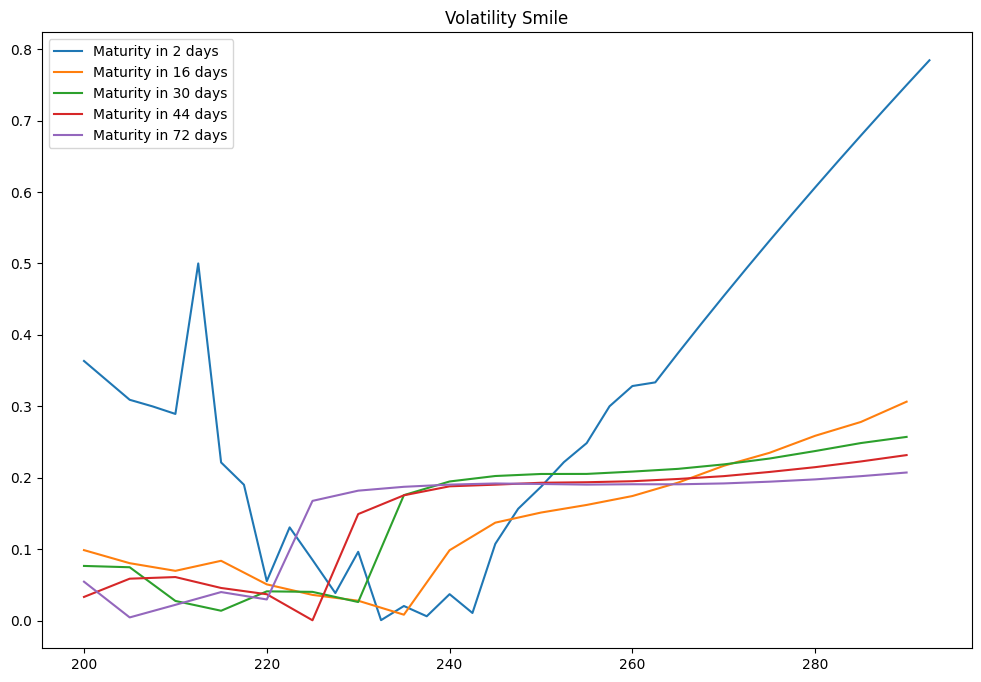

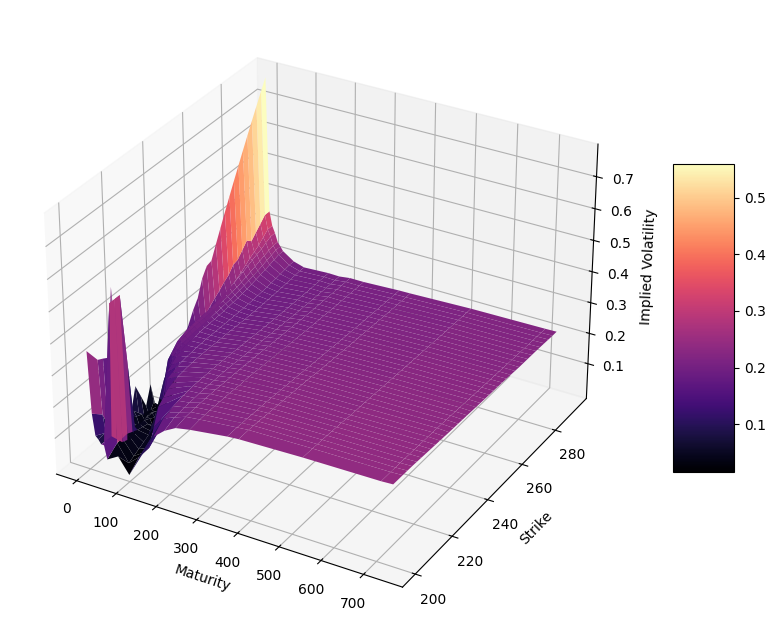

In [134]:
import yfinance as yf
import pandas as pd

def download_all_options(ticker):
    stock = yf.Ticker(ticker)
    options_dates = stock.options
    all_options = []
    S0 = yf.download(tickers=ticker, start='2025-01-01', end='2025-01-07')['Close'].iloc[-1]
    S0 = S0.values[0]
    for date in options_dates:
        opt = stock.option_chain(date)
        calls = opt.calls
        puts = opt.puts
        expiration_date = datetime.strptime(date, '%Y-%m-%d')
        timedelta = (expiration_date - datetime.today()).days
        calls['expirationDate'] = timedelta
        puts['expirationDate'] = timedelta
        calls['optionType'] = 'call'
        puts['optionType'] = 'put'
        all_options.append(calls)
        all_options.append(puts)




    all_options_df = pd.concat(all_options, ignore_index=True)


    all_options_df["midPrice"] = (all_options_df["ask"] + all_options_df["bid"]) / 2
    all_options_df["strike"] = all_options_df["strike"].astype(float)
    all_options_df = all_options_df[(S0 * 0.8 < all_options_df["strike"]) & (all_options_df["strike"] < S0 * 1.2)]
    all_options_df = all_options_df[["expirationDate", "strike", "midPrice", "optionType"]]

    return all_options_df.pivot_table(index=['expirationDate','strike'], 
                                          columns='optionType', 
                                          values='midPrice')

def BSM(sigma, S0, K, P, T, r, option):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'call':
        result = (S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)) - P
    if option == 'put':
        result = (K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)) - P
    return result



aapl_options = download_all_options("AAPL")
imp_vols = []
option_type = "call"
for index, value in aapl_options["call"].items():
    T = index[0] / 365
    K = index[1]
    sigma0 = 0.5
    imp_vol = fsolve(BSM, sigma0, args=(S0, K, value, T, r, option_type), xtol=1e-6, maxfev=500)
    imp_vols.append(float(imp_vol))



maturities = aapl_options[option_type].index.levels[0]
day1 = aapl_options[option_type].index.levels[0][0]
day2 = aapl_options[option_type].index.levels[0][2]
day3 = aapl_options[option_type].index.levels[0][4]
day4 = aapl_options[option_type].index.levels[0][6]
day5 = aapl_options[option_type].index.levels[0][7]

imp_vols_indexed = pd.Series(imp_vols, index=aapl_options[option_type].index)

plt.figure(figsize=(12, 8))
plt.title('Volatility Smile')

plt.plot(pd.Series(imp_vols, index=aapl_options[option_type].index).loc[day1], label=f'Maturity in {day1} days')
plt.plot(pd.Series(imp_vols, index=aapl_options[option_type].index).loc[day2], label=f'Maturity in {day2} days')
plt.plot(pd.Series(imp_vols, index=aapl_options[option_type].index).loc[day3], label=f'Maturity in {day3} days')
plt.plot(pd.Series(imp_vols, index=aapl_options[option_type].index).loc[day4], label=f'Maturity in {day4} days')
plt.plot(pd.Series(imp_vols, index=aapl_options[option_type].index).loc[day5], label=f'Maturity in {day5} days')

plt.legend()

#3D plot

df_interpolated = imp_vols_indexed.unstack(0).interpolate(method='linear')

x, y = np.meshgrid(np.array(aapl_options[option_type].index.levels[0]), np.array(aapl_options[option_type].index.get_level_values(1).unique()))
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, np.array(df_interpolated), cmap='magma')

plt.xlabel('Maturity')
plt.ylabel('Strike')
ax.set_zlabel('Implied Volatility')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()